# USD/THB Modeling & Evaluation Notebook

Goal: train and evaluate XGBoost models (with early stopping) on engineered FX features, using chronological train/validation/test splits.


In [5]:
# Imports
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

import project_paths  # noqa: F401
from models.train_xgboost import (
    load_data,
    create_features,
    prepare_train_test,
    train_xgboost,
)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline


## 1. Data Preparation


In [6]:
# Load FX features
print("📥 Loading FX dataset...")
df = load_data(start_date='2020-01-01')

print(f"✅ Loaded {len(df)} rows and {len(df.columns)} columns")
print(f"📅 Range: {df.index.min().date()} ➜ {df.index.max().date()}")

df.head()


📥 Loading FX dataset...
✅ Loaded 2152 rows from database
✅ Loaded 2152 rows and 14 columns
📅 Range: 2020-01-01 ➜ 2025-11-21


,usd_thb,dxy,gold,oil,vix,sp500,set_index,th_10y,th_cpi,th_policy_rate,us_10y,us_cpi,us_fed_rate,news_sentiment
date,,,,,,,,,,,,,,
2020-01-01,29.680000,96.849998,1524.500000,61.180000,12.47,3257.850098,1595.819946,1.460,1.05,1.25,1.88,259.127,1.55,959.0
2020-01-02,30.059999,96.849998,1524.500000,61.180000,12.47,3257.850098,1595.819946,1.460,1.05,1.25,1.88,259.127,1.55,1416.0
2020-01-03,30.139999,96.839996,1549.199951,63.049999,14.02,3234.850098,1594.969971,1.435,1.05,1.25,1.80,259.127,1.55,1639.0
2020-01-04,30.139999,96.839996,1549.199951,63.049999,14.02,3234.850098,1594.969971,1.435,1.05,1.25,1.80,259.127,1.55,733.0
2020-01-05,30.139999,96.839996,1549.199951,63.049999,14.02,3234.850098,1594.969971,1.435,1.05,1.25,1.80,259.127,1.55,559.0


In [9]:
# Create engineered features
print("🔧 Generating features (30-day horizon)...")
df_features = create_features(df, target_shift=30)

print(f"✅ Feature columns: {len(df_features.columns)}")
print(f"📊 Training rows available: {len(df_features)}")


🔧 Generating features (30-day horizon)...
✅ Created 67 features
   Rows after target creation: 2122
✅ Feature columns: 67
📊 Training rows available: 2122


In [11]:
# Prepare train/test split
print("📊 Splitting data into train/test sets (80/20)...")
X_train, X_test, y_train, y_test, feature_cols = prepare_train_test(df_features, test_size=0.2)

📊 Splitting data into train/test sets (80/20)...

📊 Train/Test Split:
   Train: 1673 samples (2020-01-31 00:00:00 to 2024-08-29 00:00:00)
   Test:  419 samples (2024-08-30 00:00:00 to 2025-10-22 00:00:00)
   Features: 65


## 2. Model Training


In [26]:
# Train model
print("🚀 Training XGBoost model...")
model = train_xgboost(X_train, y_train, X_test, y_test)

🚀 Training XGBoost model...

🚀 Training XGBoost model...
[0]	validation_0-rmse:2.00501	validation_1-rmse:1.00316


[100]	validation_0-rmse:0.28854	validation_1-rmse:0.71417
[200]	validation_0-rmse:0.25185	validation_1-rmse:0.68676
[300]	validation_0-rmse:0.24890	validation_1-rmse:0.68505
[400]	validation_0-rmse:0.24877	validation_1-rmse:0.68485
[499]	validation_0-rmse:0.24727	validation_1-rmse:0.68375

📈 Model Performance:
   Train MAE:  0.1943
   Test MAE:   0.5798
   Train RMSE: 0.2473
   Test RMSE:  0.6838
   Test MAPE:  1.76%


## 3. Evaluation & Diagnostics


In [24]:
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

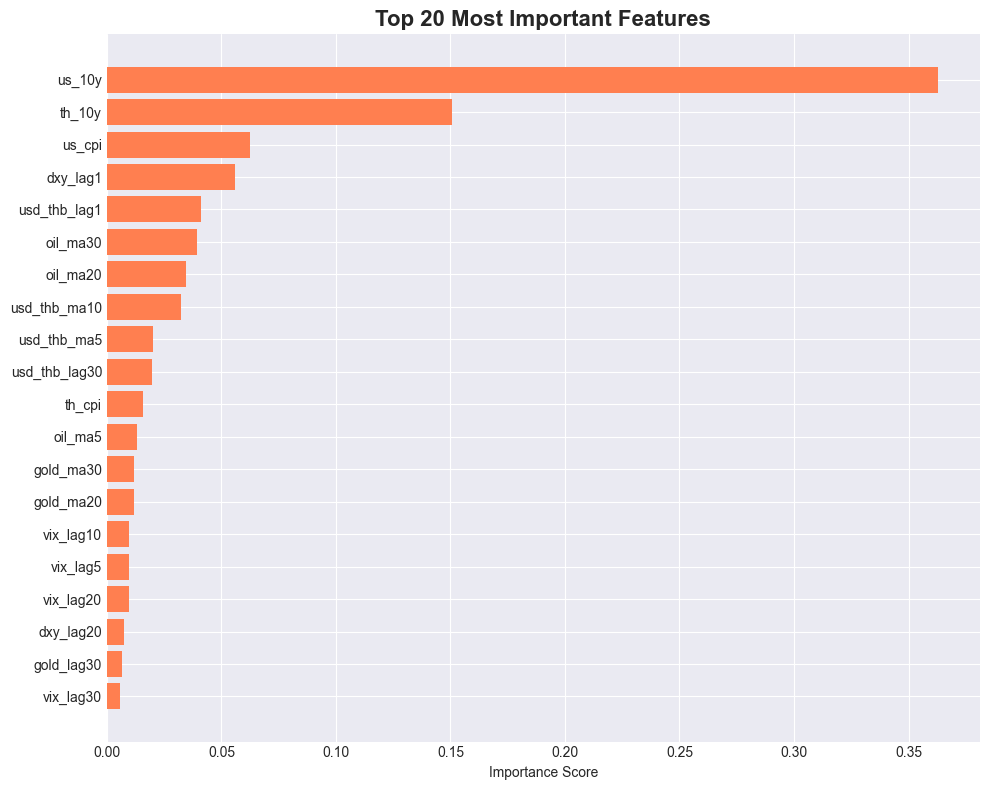


📊 Top 5 Most Important Features:
   us_10y: 0.3630
   th_10y: 0.1507
   us_cpi: 0.0624
   dxy_lag1: 0.0558
   usd_thb_lag1: 0.0411


In [25]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='coral')
plt.gca().invert_yaxis()
plt.title('Top 20 Most Important Features', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\n📊 Top 5 Most Important Features:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")


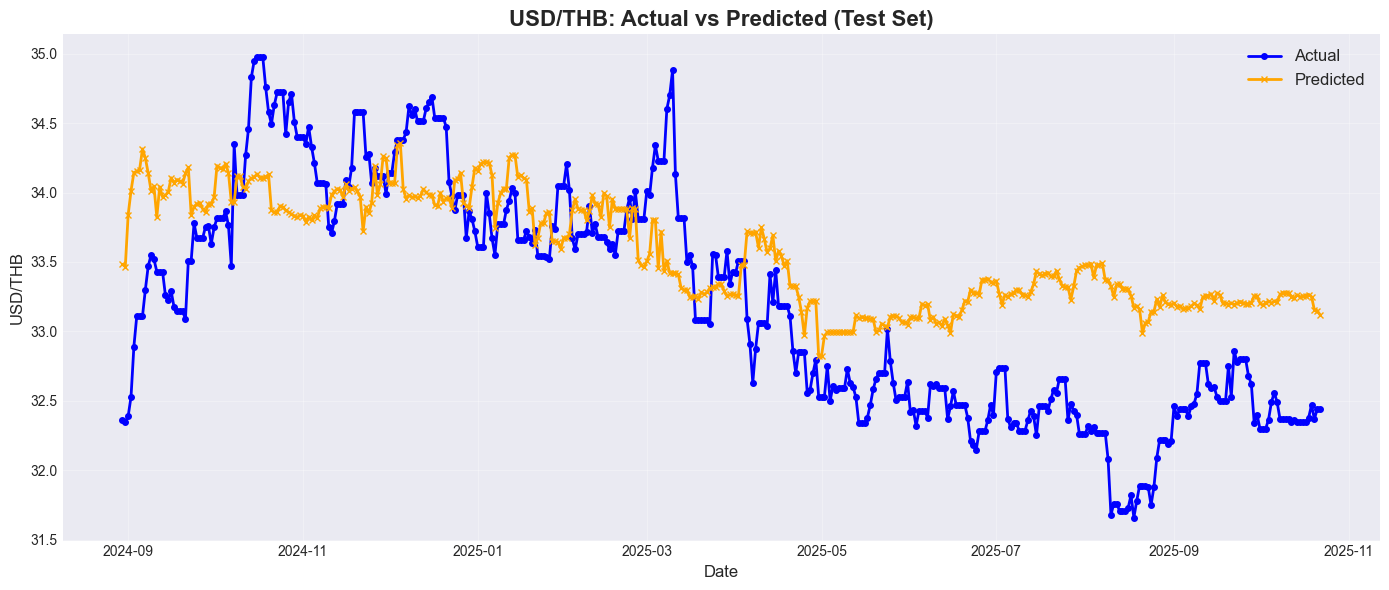

In [18]:
# Actual vs Predicted (Test set)
test_results = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_test_pred
}, index=y_test.index)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(test_results.index, test_results['actual'], label='Actual', linewidth=2, marker='o', markersize=4, color='blue')
ax.plot(test_results.index, test_results['predicted'], label='Predicted', linewidth=2, marker='x', markersize=4, color='orange')
ax.set_title('USD/THB: Actual vs Predicted (Test Set)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('USD/THB', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

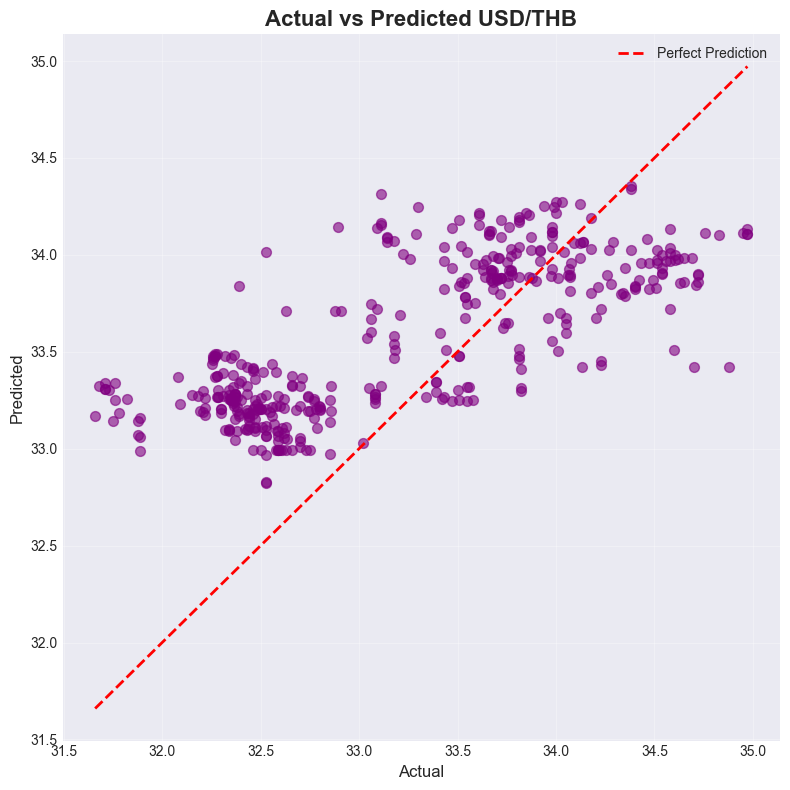

In [23]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, alpha=0.6, s=50, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.title('Actual vs Predicted USD/THB', fontsize=16, fontweight='bold')
plt.xlabel('Actual', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

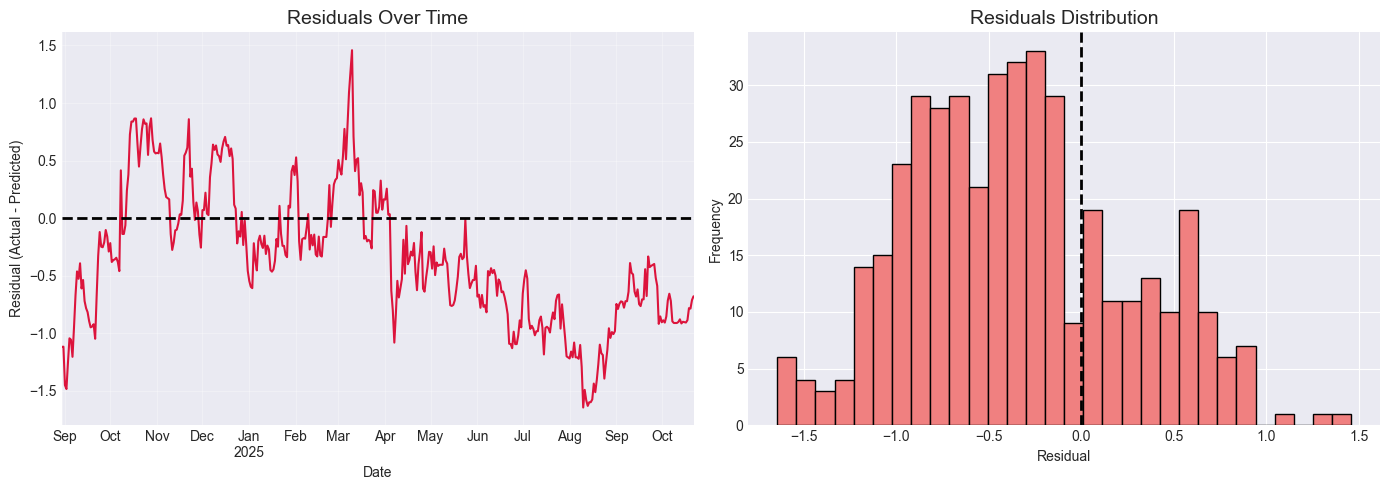


📊 Residuals Statistics:
   Mean: -0.3526
   Std Dev: 0.5865
   Min: -1.6440
   Max: 1.4587


In [22]:
# Residuals analysis
residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals over time
residuals.plot(ax=axes[0], linewidth=1.5, color='crimson')
axes[0].axhline(0, color='black', linestyle='--', linewidth=2)
axes[0].set_title('Residuals Over Time', fontsize=14)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Residual (Actual - Predicted)')
axes[0].grid(True, alpha=0.3)

# Residuals distribution
residuals.hist(bins=30, ax=axes[1], edgecolor='black', color='lightcoral')
axes[1].axvline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_title('Residuals Distribution', fontsize=14)
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\n📊 Residuals Statistics:")
print(f"   Mean: {residuals.mean():.4f}")
print(f"   Std Dev: {residuals.std():.4f}")
print(f"   Min: {residuals.min():.4f}")
print(f"   Max: {residuals.max():.4f}")